In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import random as rnd
%matplotlib inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
#n=os.listdir("Ecobici")
#df=pd.read_csv('Ecobici/2017-11.csv')

In [3]:
#df=df.truncate(after=-1)

In [4]:
#for arch in n:
#    df=pd.concat([df,pd.read_csv('Ecobici/%s'%arch)])

In [5]:
#df.reset_index(drop=True,inplace=True)
#df=df.drop('Unnamed: 9',axis=1)

In [6]:
#df=df.sample(4000000)
#df.reset_index(drop=True,inplace=True)
#df.to_csv("./ecobicisample.csv", index=False)

In [7]:
df=pd.read_csv('ecobicisample.csv')

C:\Users\ydont\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
#df=df.sample(2000000)
#df.reset_index(drop=True,inplace=True)

#### Conversiones de tipo de dato

In [9]:
%%time
df['Hora_Arribo']=pd.to_datetime(df['Hora_Arribo'])

Wall time: 4min 52s


In [10]:
%%time
df['Hora_Retiro']=pd.to_datetime(df['Hora_Retiro'])

Wall time: 4min 34s


In [11]:
%%time
df['Fecha_Arribo']=pd.to_datetime(df['Fecha_Arribo'])
df['Fecha_Retiro']=pd.to_datetime(df['Fecha_Retiro'])

Wall time: 11 s


In [12]:
df['Tiempo_Recorrido']=df['Hora_Arribo']-df['Hora_Retiro']

In [13]:
df['Ciclo_Estacion_Arribo']=df['Ciclo_Estacion_Arribo'].astype('str')
df['Ciclo_Estacion_Retiro']=df['Ciclo_Estacion_Retiro'].astype('str')

#### Esta funcion hace que todas las cicloestaciones tengan longitud de 3 caracteres

In [14]:
def ceros(x):
    if len(x)==2:
        return '0'+x
    elif len(x)==1:
        return '00'+x
    else:
        return x

df['Ciclo_Estacion_Arribo']=df['Ciclo_Estacion_Arribo'].map(ceros)
df['Ciclo_Estacion_Retiro']=df['Ciclo_Estacion_Retiro'].map(ceros)

In [15]:
#Se obtienen los viajes de la estacion A a la estacion B
df['Viaje']=df['Ciclo_Estacion_Retiro']+df['Ciclo_Estacion_Arribo']

In [17]:
viajes=pd.DataFrame(df['Viaje'].value_counts())
viajes.reset_index(inplace=True)
viajes.describe([0.8,0.9,0.99])

,Viaje
count,155223.000000
mean,25.769377
std,59.753840
min,1.000000
50%,8.000000
80%,32.000000
90%,63.000000
99%,276.000000
max,2189.000000


El 99% de los viajes ocurren menos de 300 veces (en esta muestra) por lo cual se analizaran unicamente los mas frecuentes

#### Lista de los 100 viajes mas frecuentes

In [18]:
viajes.rename(columns={"index": "Viaje", "Viaje": "Conteo"},inplace=True)
viajes.truncate(after=100)

,Viaje,Conteo
0,018001,2189
1,211217,2180
2,001018,1887
3,174111,1714
4,174183,1671
5,111174,1649
6,270266,1520
7,165163,1517
8,208242,1494
9,183174,1484


##### Se generan las columnas que se utilizaran para el clustering

In [19]:
#Para esta columna se obtiene el tiempo en segundos y se divide entre 60 para obtener los minutos
df['Tiempo_Recorrido(float)'] = df['Tiempo_Recorrido'].dt.seconds.astype(int)/60
#Se quitan outliers
df = df[df['Tiempo_Recorrido(float)'] <= 60]
df = df[df['Edad_Usuario'] <= 70]
#Se calcula la discancia aproximada asumiendo velocidad media de 13km/h y +/- 20% de variabilidad 
#La variabilidad se obtiene multiplicando la distancia del recorrido por un numero aleatorio entre 0.8 y 1.2
df['Disancia aprox. (km)']=df['Tiempo_Recorrido(float)']*(13/60)*rnd.uniform(0.8, 1.2)
#Se obtiene la hora como entero en formato de 24 horas
df['Hora (24h)'] = df['Hora_Retiro'].dt.hour.astype(int)

In [20]:
df.shape

(3961230, 14)

In [21]:
aux1=df[['Bici','Fecha_Arribo']].groupby('Bici').agg(["min", "max"])
aux1.columns=aux1.columns.droplevel()

In [22]:
#Se calcula la edad de cada bicicleta con la diferencia entre las fechas maxima y minima
aux1['Edad_Bici']=aux1['max']-aux1['min']
aux1['Edad_Bici(int)']=aux1['Edad_Bici'].dt.days
aux1.reset_index(inplace=True)

In [23]:
#Se calcula el promedio de tiempo del recorrido de cada bicicleta
aux2=df[['Bici','Edad_Usuario','Tiempo_Recorrido(float)']].groupby('Bici').agg(["mean"])
aux2.columns=aux2.columns.droplevel()
aux2.columns=['Edad_Usuario(promedio)','Tiempo_recorrido(promedio)']

In [24]:
df=df.merge(aux1[['Bici','Edad_Bici(int)']],on='Bici',how='inner')
df=df.merge(aux2,on='Bici',how='inner')

#### Tabla final

In [25]:
df.head(2)

,Bici,Ciclo_Estacion_Arribo,Ciclo_Estacion_Retiro,Edad_Usuario,Fecha_Arribo,Fecha_Retiro,Genero_Usuario,Hora_Arribo,Hora_Retiro,Tiempo_Recorrido,Viaje,Tiempo_Recorrido(float),Disancia aprox. (km),Hora (24h),Edad_Bici(int),Edad_Usuario(promedio),Tiempo_recorrido(promedio)
0,11072,286,446,69,2018-11-18,2018-11-18,M,2020-01-07 11:11:32,2020-01-07 10:19:07,00:52:25,446286,52.416667,12.363699,10,701,35.793436,13.255438
1,11072,385,444,38,2018-05-29,2018-05-29,F,2020-01-07 08:25:57,2020-01-07 08:06:04,00:19:53,444385,19.883333,4.689950,8,701,35.793436,13.255438


# Reduccion de dimensiones y visualización

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BEF71AE348>,
      dtype=object)

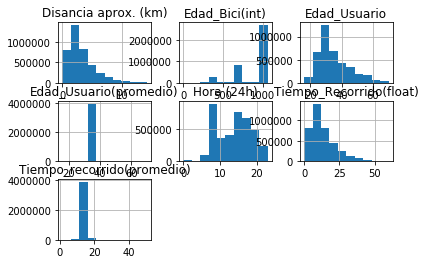

In [28]:
df.hist()

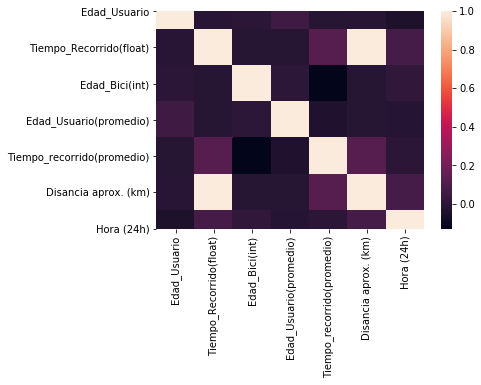

In [50]:
sns.heatmap(df.corr())

In [29]:
ls_cont=['Edad_Usuario','Tiempo_Recorrido(float)','Edad_Bici(int)','Edad_Usuario(promedio)','Tiempo_recorrido(promedio)',
        'Disancia aprox. (km)','Hora (24h)']
ls_disc=['Bici', 'Ciclo_Estacion_Arribo', 'Ciclo_Estacion_Retiro', 'Genero_Usuario']
smp=df.sample(2000)

In [30]:
#PCA
sc = StandardScaler()
sc.fit(smp[ls_cont])
xm = pd.DataFrame(sc.transform(smp[ls_cont]), columns = smp[ls_cont].columns)

pca = PCA(n_components=2)
pca.fit(xm)

xp = pd.DataFrame(pca.transform(xm), columns = ['p1', 'p2'])

In [31]:
pca.explained_variance_ratio_.cumsum()

array([0.2918559 , 0.45167954])

In [32]:
%%time
#MDS
mm = MinMaxScaler()
mm.fit(smp[ls_cont])
xmm = pd.DataFrame(mm.transform(smp[ls_cont]), columns = smp[ls_cont].columns)

mds = MDS(n_components=2)
xd = pd.DataFrame(mds.fit_transform(xmm), columns = ['d1', 'd2'])

Wall time: 5min 29s


In [33]:
%%time
#TSNE
tsne = TSNE()

xt = pd.DataFrame(tsne.fit_transform(smp[ls_cont]), columns = ['t1','t2'])

Wall time: 19.9 s


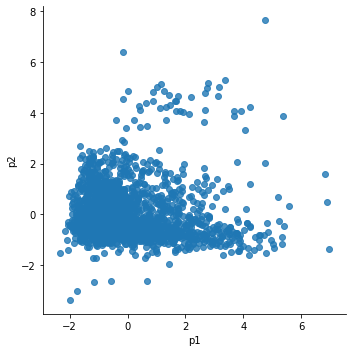

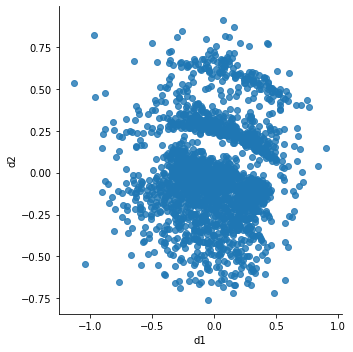

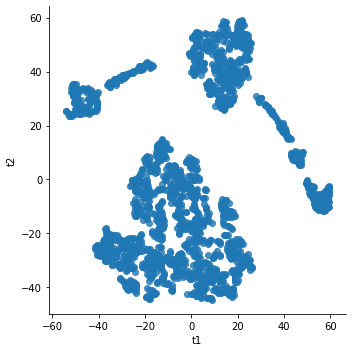

In [34]:
sns.lmplot(x = 'p1', y = 'p2', data = xp, fit_reg=False)
sns.lmplot(x = 'd1', y = 'd2', data = xd, fit_reg=False)
sns.lmplot(x = 't1', y = 't2', data = xt, fit_reg=False)

# Clusters

In [35]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

## Average

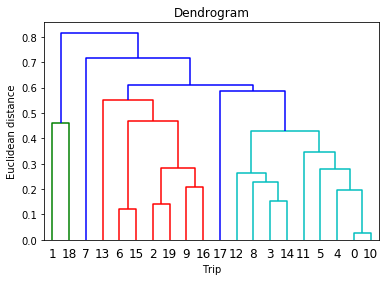

In [36]:
dendrogram = sch.dendrogram(sch.linkage(xmm.sample(20), method = 'average'))
plt.title('Dendrogram')
plt.xlabel('Trip')
plt.ylabel('Euclidean distance')
plt.show()

In [37]:
avg_clus = AgglomerativeClustering(linkage='average',
                                  n_clusters=5)

In [38]:
xp['Avg Cluster'] = xd['Avg Cluster'] = xt['Avg Cluster'] = avg_clus.fit_predict(xmm)

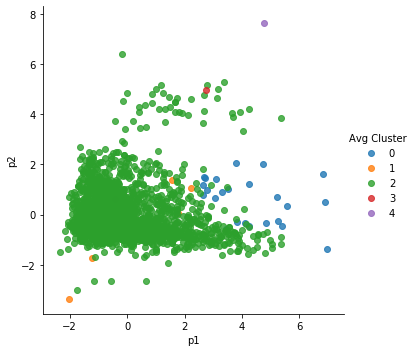

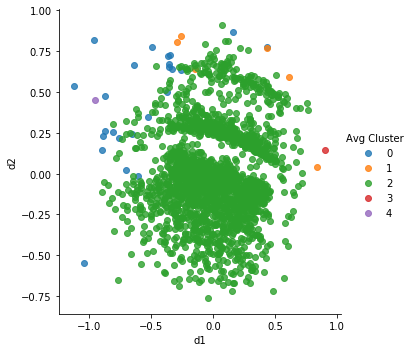

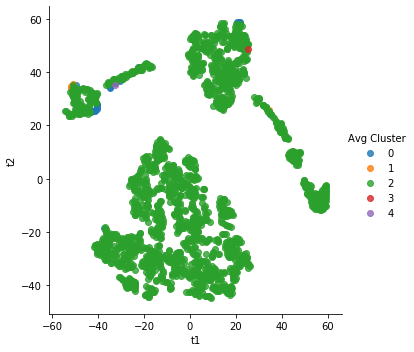

In [39]:
sns.lmplot(x = 'p1', y = 'p2', data = xp, fit_reg=False, hue='Avg Cluster')
sns.lmplot(x = 'd1', y = 'd2', data = xd, fit_reg=False, hue='Avg Cluster')
sns.lmplot(x = 't1', y = 't2', data = xt, fit_reg=False, hue='Avg Cluster')

## Ward

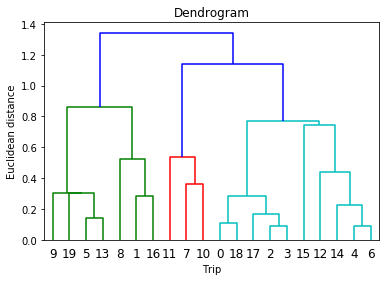

In [40]:
dendrogram = sch.dendrogram(sch.linkage(xmm.sample(20), method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Trip')
plt.ylabel('Euclidean distance')
plt.show()

In [41]:
ward_clus = AgglomerativeClustering(linkage='ward',
                                  n_clusters=5)

In [42]:
xp['ward Cluster'] = xd['ward Cluster'] = xt['ward Cluster'] = ward_clus.fit_predict(xmm)

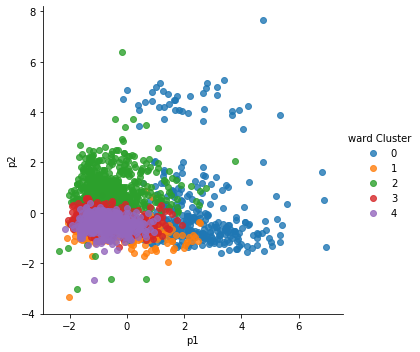

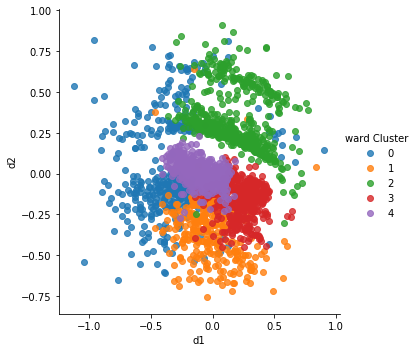

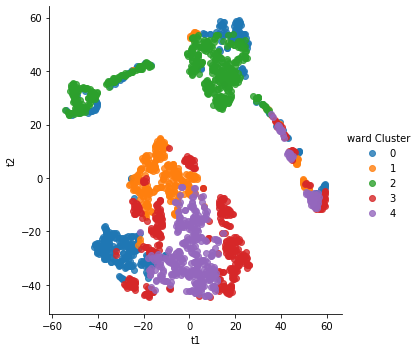

In [43]:
sns.lmplot(x = 'p1', y = 'p2', data = xp, fit_reg=False, hue='ward Cluster')
sns.lmplot(x = 'd1', y = 'd2', data = xd, fit_reg=False, hue='ward Cluster')
sns.lmplot(x = 't1', y = 't2', data = xt, fit_reg=False, hue='ward Cluster')

## Centroid

In [44]:
from scipy.cluster import hierarchy

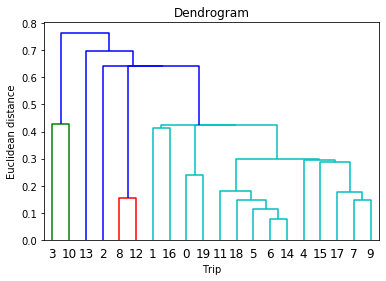

In [45]:
dendrogram = sch.dendrogram(sch.linkage(xmm.sample(20, random_state=123), method = 'centroid'))
plt.title('Dendrogram')
plt.xlabel('Trip')
plt.ylabel('Euclidean distance')
plt.show()

In [46]:
from scipy.cluster.hierarchy import fcluster, centroid
from scipy.spatial.distance import pdist

In [47]:
y = pdist(xmm)
z = centroid(y)
xp['Centroid Cluster'] = xd['Centroid Cluster'] = xt['Centroid Cluster'] = list(fcluster(sch.linkage(xmm, method = 'centroid'),t=3,criterion='distance'))

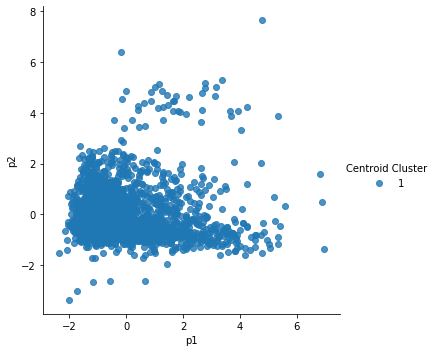

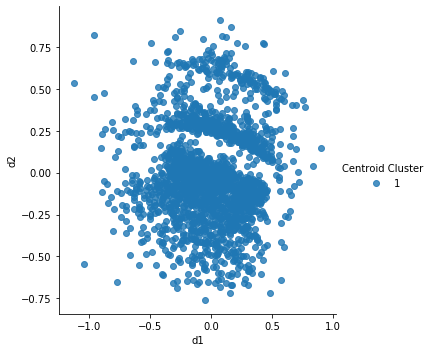

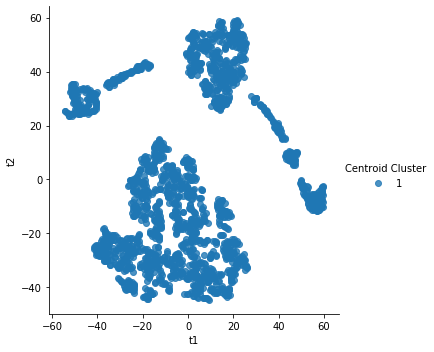

In [48]:
sns.lmplot(x = 'p1', y = 'p2', data = xp, fit_reg=False, hue='Centroid Cluster')
sns.lmplot(x = 'd1', y = 'd2', data = xd, fit_reg=False, hue='Centroid Cluster')
sns.lmplot(x = 't1', y = 't2', data = xt, fit_reg=False, hue='Centroid Cluster')